In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nitk-bank/Untitled spreadsheet - bank-full.csv


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Load the bank marketing dataset
df = pd.read_csv('/kaggle/input/nitk-bank/Untitled spreadsheet - bank-full.csv')

# Create personas
def create_personas(row):
    if row['age'] < 30:
        return 'Tech-Savvy Millennial'
    elif 30 <= row['age'] < 45 and row['job'] in ['management', 'admin.']:
        return 'Busy Professional'
    elif row['job'] in ['entrepreneur', 'self-employed']:
        return 'Small Business Owner'
    elif row['age'] > 60:
        return 'Retiree'
    elif row['education'] == 'tertiary' and row['balance'] > df['balance'].quantile(0.75):
        return 'HNI'
    else:
        return 'New-to-Banking'

# Add persona column
df['persona'] = df.apply(create_personas, axis=1)

# Create synthetic feature adoption data
features = ['mobile_banking', 'smart_assistant', 'card_management', 'investment_tools']
for feature in features:
    # Create adoption (0 or 1)
    df[f'{feature}_adopted'] = np.random.choice([0, 1], size=len(df), p=[0.3, 0.7])
    
    # Create engagement score (0-10)
    df[f'{feature}_engagement'] = np.where(
        df[f'{feature}_adopted'] == 1,
        np.random.uniform(1, 10, len(df)),
        0
    )
    
    # Create time to adoption (days)
    df[f'{feature}_time_to_adopt'] = np.where(
        df[f'{feature}_adopted'] == 1,
        np.random.exponential(30, len(df)),
        np.nan
    )

# Add tech savviness score
df['tech_savviness'] = np.where(
    df['education'] == 'tertiary',
    np.random.uniform(7, 10, len(df)),
    np.random.uniform(3, 7, len(df))
)

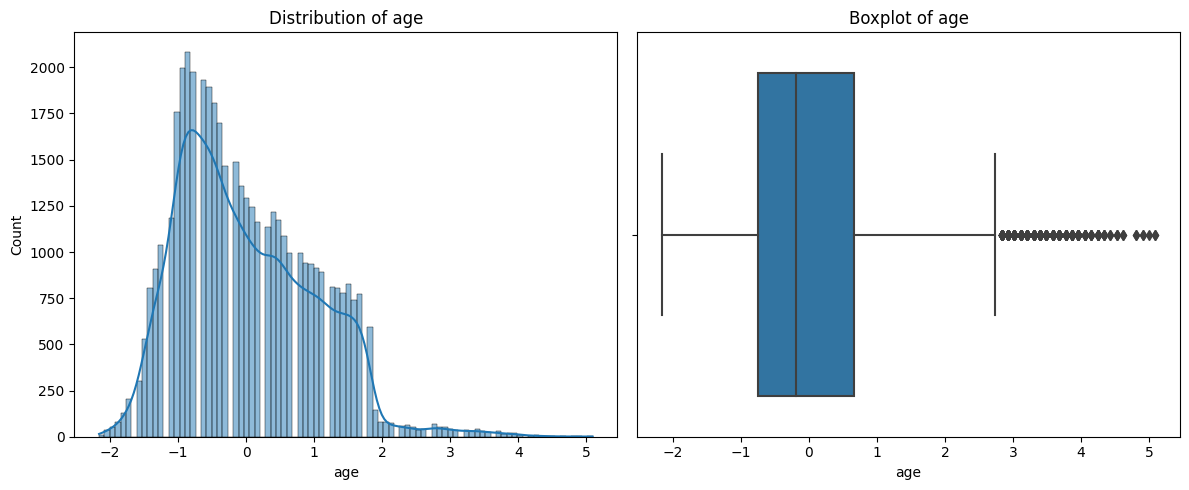

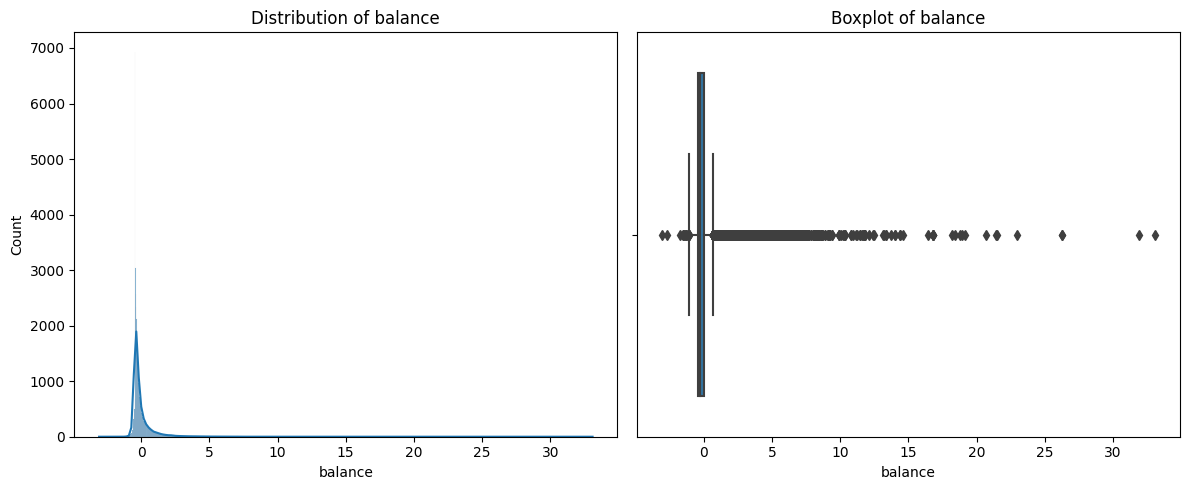

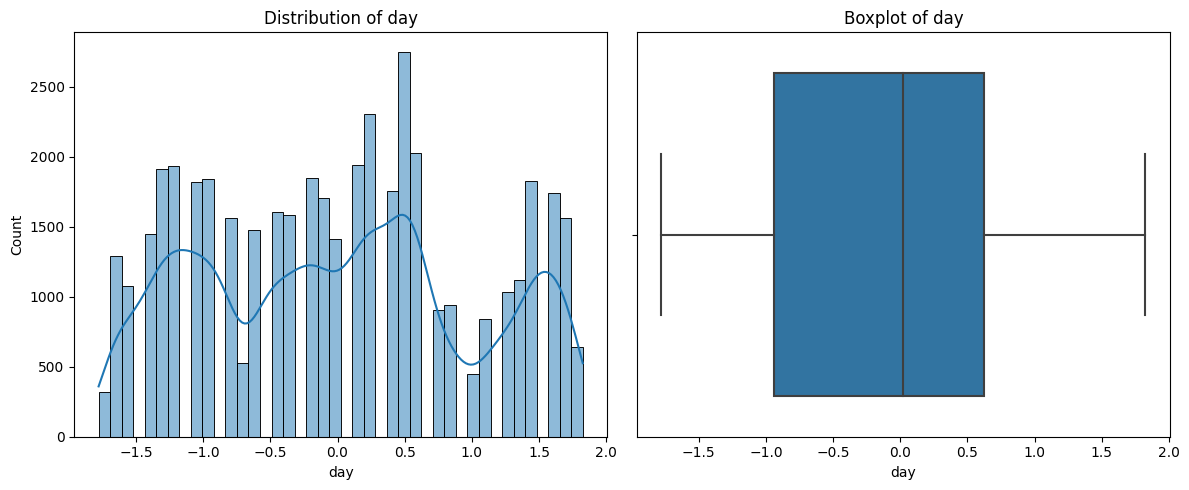

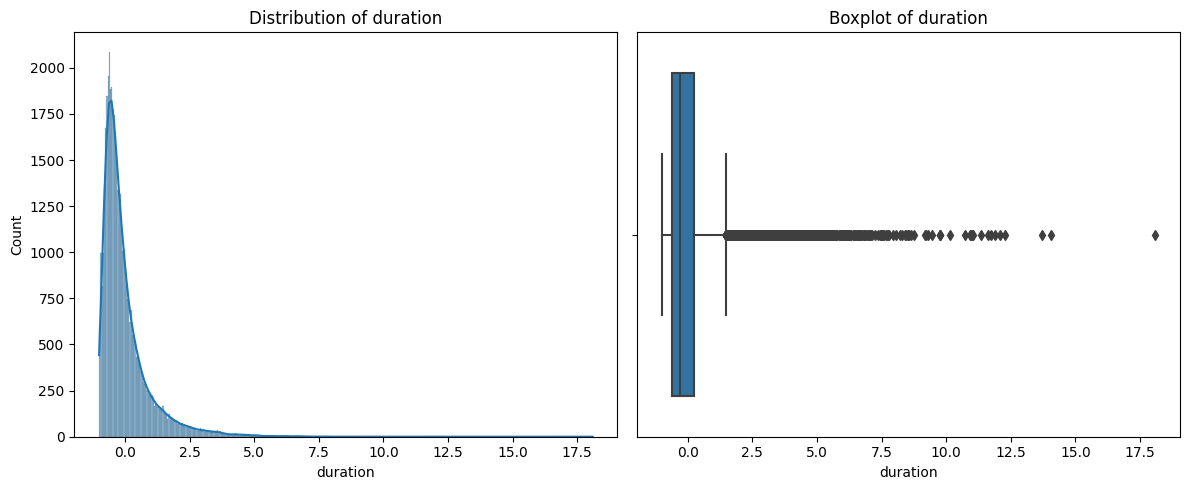

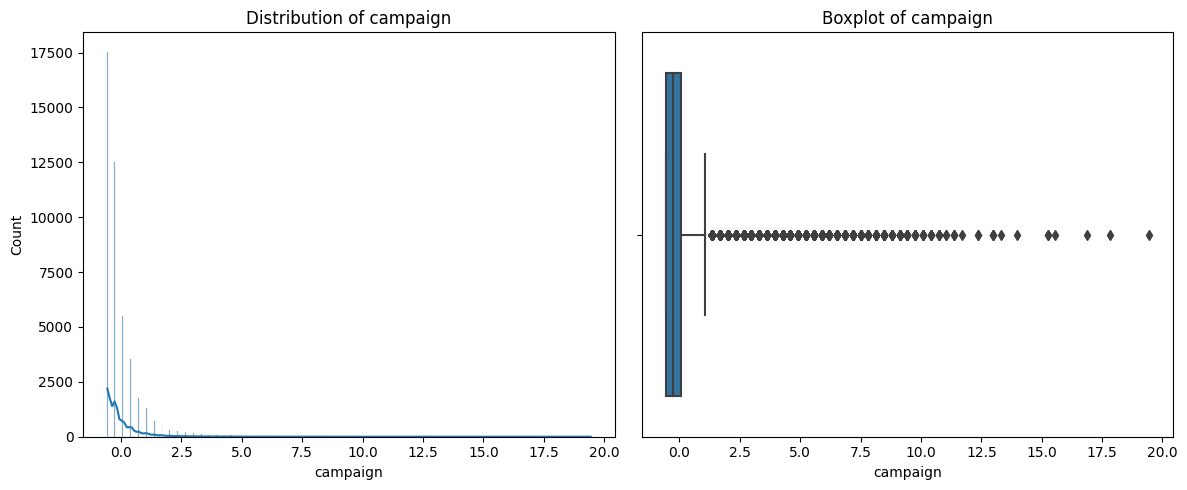

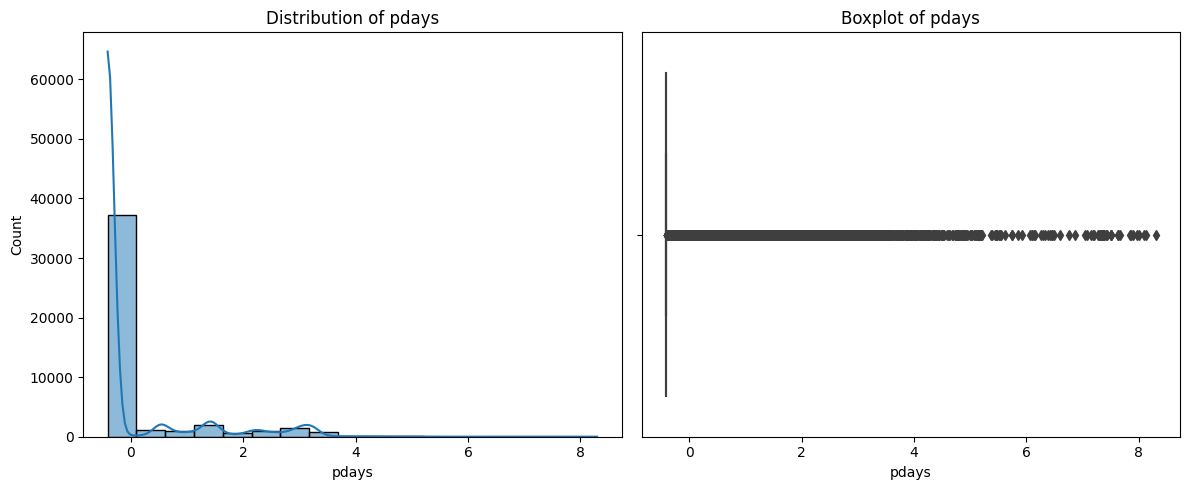

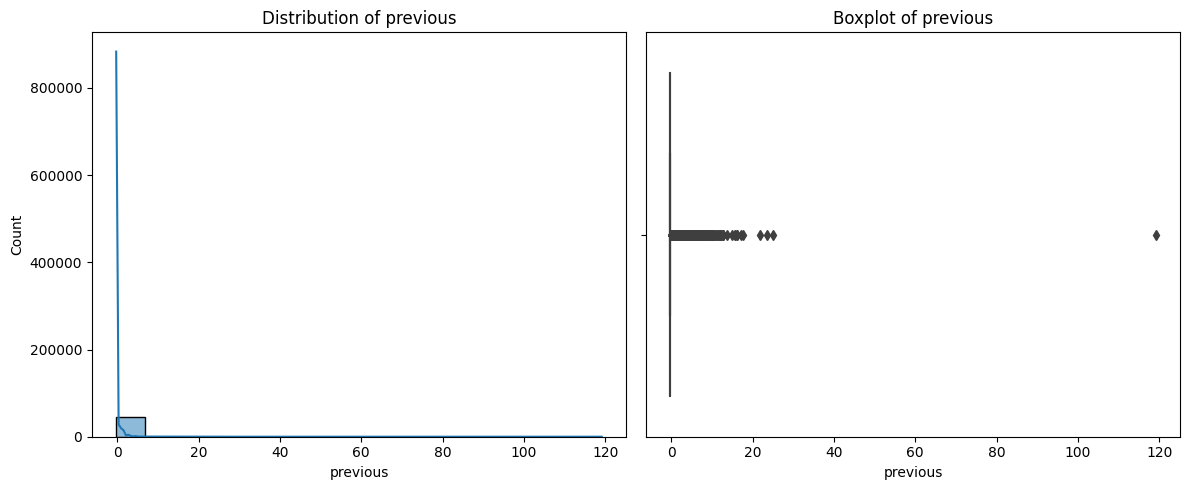

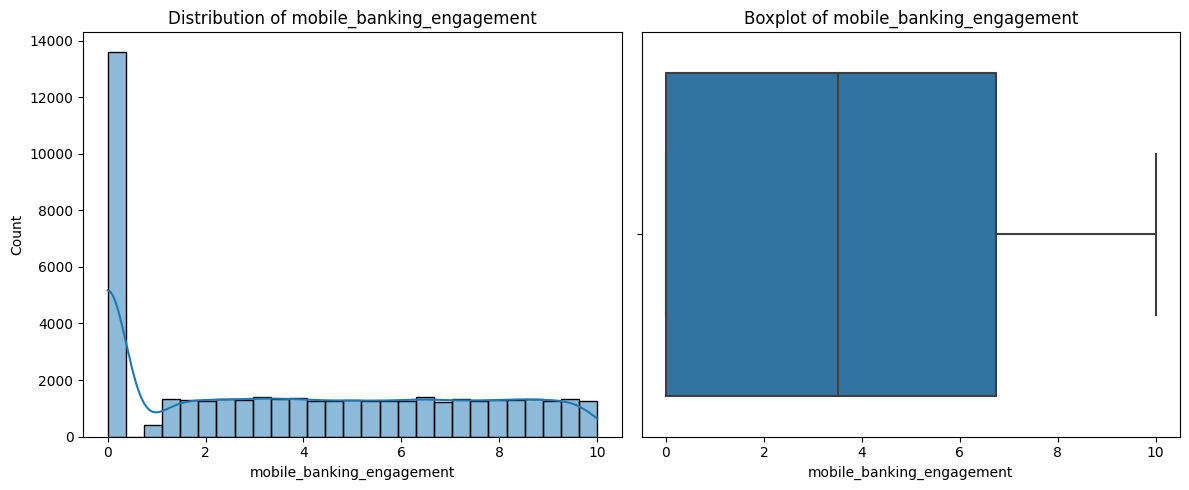

KeyError: 'mobile_banking_time_to_adopt'

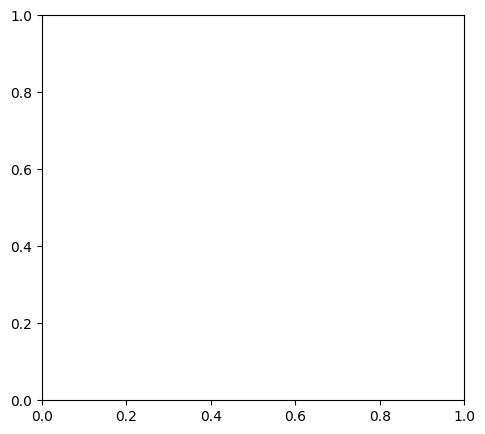

In [13]:
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous', 
                  'mobile_banking_engagement', 'mobile_banking_time_to_adopt',
                  'smart_assistant_engagement', 'smart_assistant_time_to_adopt',
                  'card_management_engagement', 'card_management_time_to_adopt',
                  'investment_tools_engagement', 'investment_tools_time_to_adopt',
                  'tech_savviness']

for col in numerical_cols:
    plt.figure(figsize=(12, 5))
    plt.subplot(121)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.subplot(122)
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

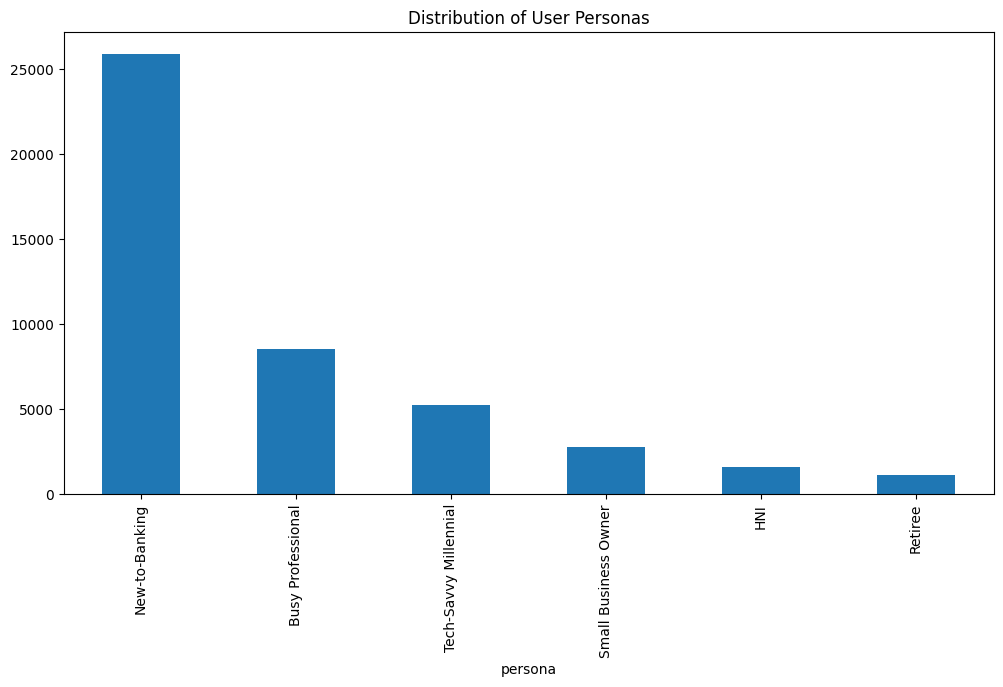

<Figure size 1200x600 with 0 Axes>

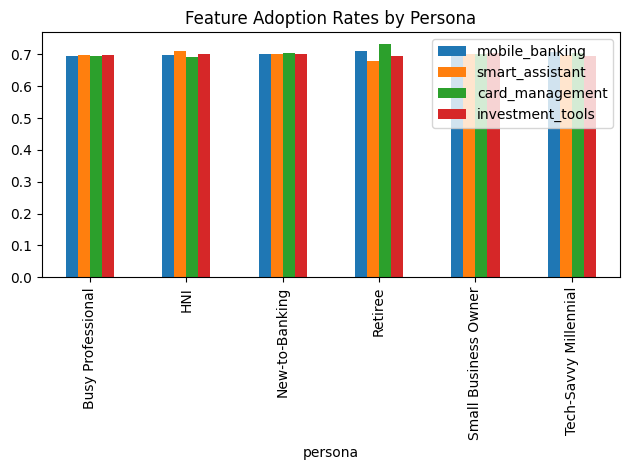

In [5]:
# Basic persona analysis
def analyze_personas():
    # Distribution of personas
    plt.figure(figsize=(12, 6))
    df['persona'].value_counts().plot(kind='bar')
    plt.title('Distribution of User Personas')
    plt.show()
    
    # Feature adoption by persona
    adoption_by_persona = pd.DataFrame()
    for feature in features:
        adoption_by_persona[feature] = df.groupby('persona')[f'{feature}_adopted'].mean()
    
    plt.figure(figsize=(12, 6))
    adoption_by_persona.plot(kind='bar')
    plt.title('Feature Adoption Rates by Persona')
    plt.tight_layout()
    plt.show()

analyze_personas()

In [6]:
def prepare_features(df):
    # Categorical features to encode
    cat_features = ['job', 'marital', 'education', 'default', 'housing', 
                   'loan', 'contact', 'month', 'poutcome', 'persona']
    
    # Numerical features to scale
    num_features = ['age', 'balance', 'day', 'duration', 'campaign', 
                   'pdays', 'previous', 'tech_savviness']
    
    # Encode categorical features
    le = LabelEncoder()
    for col in cat_features:
        df[f'{col}_encoded'] = le.fit_transform(df[col])
    
    # Scale numerical features
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    
    # Create feature matrix
    feature_cols = [f'{col}_encoded' for col in cat_features] + num_features
    
    return df, feature_cols

df_processed, feature_cols = prepare_features(df)

In [7]:
class FeaturePredictionModel:
    def __init__(self):
        self.adoption_model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.engagement_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        self.feature_cols = None
    
    def train(self, df, feature_cols, feature_name):
        self.feature_cols = feature_cols
        
        # Train adoption model
        X = df[feature_cols]
        y_adopt = df[f'{feature_name}_adopted']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y_adopt, test_size=0.2)
        self.adoption_model.fit(X_train, y_train)
        
        # Train engagement model (only for adopted features)
        mask = df[f'{feature_name}_adopted'] == 1
        X_eng = df[mask][feature_cols]
        y_eng = df[mask][f'{feature_name}_engagement']
        
        self.engagement_model.fit(X_eng, y_eng)
        
        # Print model performance
        y_pred = self.adoption_model.predict(X_test)
        print(f"\nAdoption Model Performance for {feature_name}:")
        print(classification_report(y_test, y_pred))
    
    def predict(self, user_data):
        # Predict adoption probability
        adoption_prob = self.adoption_model.predict_proba(user_data[self.feature_cols])[:, 1]
        
        # Predict engagement score for likely adopters
        engagement_score = np.where(
            adoption_prob > 0.5,
            self.engagement_model.predict(user_data[self.feature_cols]),
            0
        )
        
        return adoption_prob, engagement_score

# Train models for each feature
models = {}
for feature in features:
    print(f"\nTraining models for {feature}")
    models[feature] = FeaturePredictionModel()
    models[feature].train(df_processed, feature_cols, feature)


Training models for mobile_banking

Adoption Model Performance for mobile_banking:
              precision    recall  f1-score   support

           0       0.28      0.01      0.02      2688
           1       0.70      0.99      0.82      6355

    accuracy                           0.70      9043
   macro avg       0.49      0.50      0.42      9043
weighted avg       0.58      0.70      0.58      9043


Training models for smart_assistant

Adoption Model Performance for smart_assistant:
              precision    recall  f1-score   support

           0       0.31      0.01      0.02      2744
           1       0.70      0.99      0.82      6299

    accuracy                           0.69      9043
   macro avg       0.50      0.50      0.42      9043
weighted avg       0.58      0.69      0.58      9043


Training models for card_management

Adoption Model Performance for card_management:
              precision    recall  f1-score   support

           0       0.28      0.01  

In [8]:
def predict_persona_reactions(new_feature_data, persona_data):
    results = []
    
    for _, user in persona_data.iterrows():
        user_predictions = {
            'persona': user['persona'],
            'predictions': {}
        }
        
        for feature in features:
            adoption_prob, engagement = models[feature].predict(user.to_frame().T)
            
            user_predictions['predictions'][feature] = {
                'adoption_probability': adoption_prob[0],
                'expected_engagement': engagement[0],
                'risk_score': 1 - adoption_prob[0] if engagement[0] > 5 else 0.5
            }
        
        results.append(user_predictions)
    
    return results

In [9]:
def predict_persona_reactions(new_feature_data, persona_data):
    results = []
    
    for _, user in persona_data.iterrows():
        user_predictions = {
            'persona': user['persona'],
            'predictions': {}
        }
        
        for feature in features:
            adoption_prob, engagement = models[feature].predict(user.to_frame().T)
            
            user_predictions['predictions'][feature] = {
                'adoption_probability': adoption_prob[0],
                'expected_engagement': engagement[0],
                'risk_score': 1 - adoption_prob[0] if engagement[0] > 5 else 0.5
            }
        
        results.append(user_predictions)
    
    return results

In [10]:
def visualize_predictions(predictions):
    # Prepare data for visualization
    personas = [p['persona'] for p in predictions]
    feature_adoption = {f: [] for f in features}
    feature_engagement = {f: [] for f in features}
    
    for pred in predictions:
        for feature in features:
            feature_adoption[feature].append(
                pred['predictions'][feature]['adoption_probability']
            )
            feature_engagement[feature].append(
                pred['predictions'][feature]['expected_engagement']
            )
    
    # Plot adoption probabilities
    plt.figure(figsize=(12, 6))
    x = np.arange(len(personas))
    width = 0.15
    
    for i, feature in enumerate(features):
        plt.bar(x + i*width, feature_adoption[feature], 
                width, label=feature)
    
    plt.xlabel('Personas')
    plt.ylabel('Adoption Probability')
    plt.title('Predicted Feature Adoption by Persona')
    plt.xticks(x + width*len(features)/2, personas, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

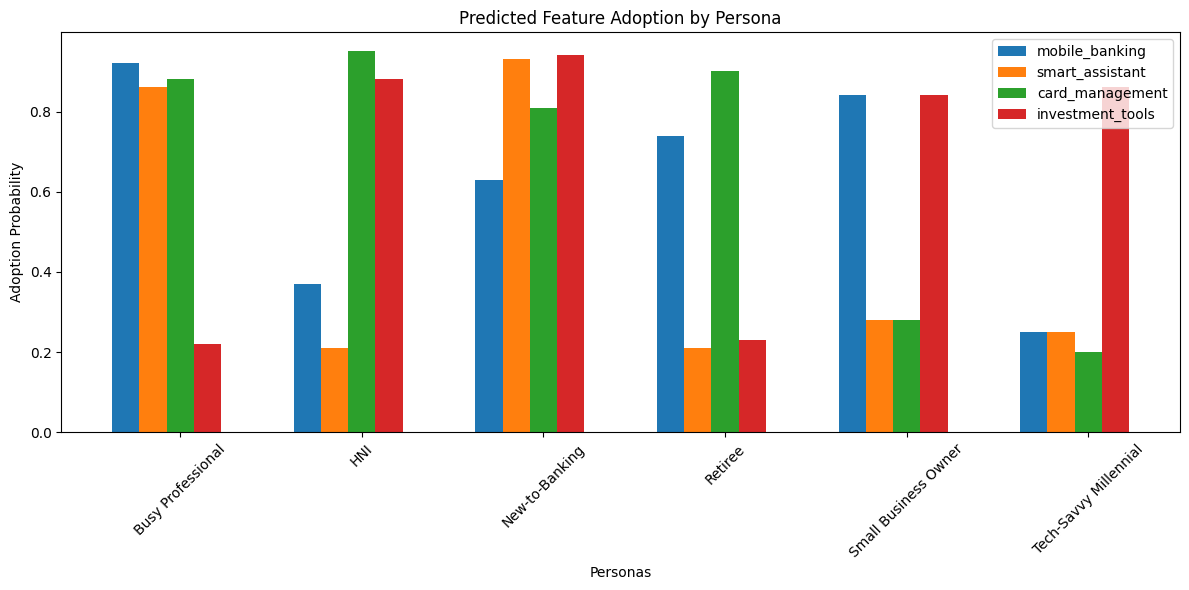


Insights for Busy Professional:

mobile_banking:
- Adoption Probability: 92.00%
- Expected Engagement: 5.7/10

smart_assistant:
- Adoption Probability: 86.00%
- Expected Engagement: 5.5/10

card_management:
- Adoption Probability: 88.00%
- Expected Engagement: 5.4/10

investment_tools:
- Adoption Probability: 22.00%
- Expected Engagement: 0.0/10

Insights for HNI:

mobile_banking:
- Adoption Probability: 37.00%
- Expected Engagement: 0.0/10

smart_assistant:
- Adoption Probability: 21.00%
- Expected Engagement: 0.0/10

card_management:
- Adoption Probability: 95.00%
- Expected Engagement: 5.4/10

investment_tools:
- Adoption Probability: 88.00%
- Expected Engagement: 5.4/10

Insights for New-to-Banking:

mobile_banking:
- Adoption Probability: 63.00%
- Expected Engagement: 5.5/10

smart_assistant:
- Adoption Probability: 93.00%
- Expected Engagement: 5.3/10

card_management:
- Adoption Probability: 81.00%
- Expected Engagement: 5.5/10

investment_tools:
- Adoption Probability: 94.00%


In [11]:
def simulate_new_feature():
    # Simulate a new feature input
    new_feature = {
        'name': 'AI Financial Assistant',
        'complexity': 7,
        'privacy_sensitivity': 8,
        'time_investment': 5,
        'ui_changes': 6
    }
    
    # Get sample users from each persona
    persona_samples = df_processed.groupby('persona').first().reset_index()
    
    # Get predictions
    predictions = predict_persona_reactions(new_feature, persona_samples)
    
    # Visualize results
    visualize_predictions(predictions)
    
    # Print detailed insights
    for pred in predictions:
        print(f"\nInsights for {pred['persona']}:")
        for feature, metrics in pred['predictions'].items():
            print(f"\n{feature}:")
            print(f"- Adoption Probability: {metrics['adoption_probability']:.2%}")
            print(f"- Expected Engagement: {metrics['expected_engagement']:.1f}/10")

# Run simulation
simulate_new_feature()

In [12]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier, XGBRegressor

# Load and process data (keeping your existing data processing code)
df = pd.read_csv('/kaggle/input/nitk-bank/Untitled spreadsheet - bank-full.csv')

# Create personas (keeping your existing persona creation)
def create_personas(row):
    if row['age'] < 30:
        return 'Tech-Savvy Millennial'
    elif 30 <= row['age'] < 45 and row['job'] in ['management', 'admin.']:
        return 'Busy Professional'
    elif row['job'] in ['entrepreneur', 'self-employed']:
        return 'Small Business Owner'
    elif row['age'] > 60:
        return 'Retiree'
    elif row['education'] == 'tertiary' and row['balance'] > df['balance'].quantile(0.75):
        return 'HNI'
    else:
        return 'New-to-Banking'

df['persona'] = df.apply(create_personas, axis=1)

# Create synthetic feature adoption data
features = ['mobile_banking', 'smart_assistant', 'card_management', 'investment_tools']
for feature in features:
    df[f'{feature}_adopted'] = np.random.choice([0, 1], size=len(df), p=[0.3, 0.7])
    df[f'{feature}_engagement'] = np.where(
        df[f'{feature}_adopted'] == 1,
        np.random.uniform(1, 10, len(df)),
        0
    )

df['tech_savviness'] = np.where(
    df['education'] == 'tertiary',
    np.random.uniform(7, 10, len(df)),
    np.random.uniform(3, 7, len(df))
)

# Feature engineering
def prepare_features(df):
    # Create copies of encoders/scalers to save
    encoders = {}
    
    # Categorical features to encode
    cat_features = ['job', 'marital', 'education', 'default', 'housing', 
                   'loan', 'contact', 'month', 'poutcome', 'persona']
    
    # Numerical features to scale
    num_features = ['age', 'balance', 'day', 'duration', 'campaign', 
                   'pdays', 'previous', 'tech_savviness']
    
    # Encode categorical features
    for col in cat_features:
        le = LabelEncoder()
        df[f'{col}_encoded'] = le.fit_transform(df[col])
        encoders[col] = le
    
    # Scale numerical features
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    
    # Create feature matrix
    feature_cols = [f'{col}_encoded' for col in cat_features] + num_features
    
    return df, feature_cols, encoders, scaler

df_processed, feature_cols, encoders, scaler = prepare_features(df)

# Train and save models
class FeaturePredictionModel:
    def __init__(self):
        self.adoption_model = XGBClassifier(n_estimators=100, random_state=42)
        self.engagement_model = XGBRegressor(n_estimators=100, random_state=42)
        self.feature_cols = None
    
    def train(self, df, feature_cols, feature_name):
        self.feature_cols = feature_cols
        
        # Train adoption model
        X = df[feature_cols]
        y_adopt = df[f'{feature_name}_adopted']
        self.adoption_model.fit(X, y_adopt)
        
        # Train engagement model
        mask = df[f'{feature_name}_adopted'] == 1
        X_eng = df[mask][feature_cols]
        y_eng = df[mask][f'{feature_name}_engagement']
        self.engagement_model.fit(X_eng, y_eng)
    
    def save_models(self, feature_name):
        # Save models
        with open(f'models/{feature_name}_adoption_model.pkl', 'wb') as f:
            pickle.dump(self.adoption_model, f)
        with open(f'models/{feature_name}_engagement_model.pkl', 'wb') as f:
            pickle.dump(self.engagement_model, f)

# Create models directory
import os
if not os.path.exists('models'):
    os.makedirs('models')

# Train and save models
models = {}
for feature in features:
    print(f"\nTraining models for {feature}")
    models[feature] = FeaturePredictionModel()
    models[feature].train(df_processed, feature_cols, feature)
    models[feature].save_models(feature)

# Save feature columns, encoders, and scaler
with open('models/feature_cols.pkl', 'wb') as f:
    pickle.dump(feature_cols, f)
with open('models/encoders.pkl', 'wb') as f:
    pickle.dump(encoders, f)
with open('models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("\nAll models and preprocessing objects have been saved to the 'models' directory.")


Training models for mobile_banking

Training models for smart_assistant

Training models for card_management

Training models for investment_tools

All models and preprocessing objects have been saved to the 'models' directory.
